# 연직단면도 그리기
- 간단한 vertical cross section 그리기
- 대기의 연직 구조를 파악하는 데 도움이 됨
- https://unidata.github.io/MetPy/latest/examples/cross_section.html#sphx-glr-examples-cross-section-py 참조

In [2]:
# 자료 내려받기
from siphon.simplewebservice.wyoming import WyomingUpperAir
import cdsapi

# 자료 다루기
from datetime import datetime
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units
from metpy.interpolate import cross_section
from scipy.ndimage import gaussian_filter

# 그림 그리기
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 사례에 대해 자료 받기

In [3]:
dt = datetime(2011,1,15,0)
path = 'C:\\Users\\DongGyu_Hyeon\\'
fname1 = 'era5_sfc_' + dt.strftime("%Y%m%d%H") + '.nc'
fname2 = 'era5_pres_' + dt.strftime("%Y%m%d%H") + '.nc'


In [14]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '2m_temperature', 'mean_sea_level_pressure',
        ],
        'year': dt.year,
        'month': dt.month,
        'day': dt.day,
        'time': dt.hour,
        'grid': [1.0, 1.0],
        
    },
    path + fname1)

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': 
        ['temperature', 'geopotential', 'u_component_of_wind', 'v_component_of_wind', 'specific_humidity'],
        'pressure_level': 
        ['200', '300', '500','600','700','850', '925','1000'],
        'year': dt.year,
        'month': dt.month,
        'day': dt.day,
        'time': dt.hour,
        'grid': [1.0, 1.0],
    },
    path + fname2)

2020-11-18 23:53:19,139 INFO Welcome to the CDS
2020-11-18 23:53:19,140 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-11-18 23:53:20,363 INFO Request is completed
2020-11-18 23:53:20,365 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data1/adaptor.mars.internal-1605683131.1086597-13529-36-afaf18c9-f99f-443a-ba52-9fa68503b810.nc to C:\Users\DongGyu_Hyeon\era5_sfc_2011011500.nc (258K)
2020-11-18 23:53:22,630 INFO Download rate 114K/s                                                                      
2020-11-18 23:53:24,123 INFO Welcome to the CDS
2020-11-18 23:53:24,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-11-18 23:53:24,487 INFO Request is queued
2020-11-18 23:53:25,775 INFO Request is running
2020-11-18 23:53:30,111 INFO Request is completed
2020-11-18 23:53:30,113 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/

Result(content_length=5217396,content_type=application/x-netcdf,location=http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1605711207.1820064-27062-7-63d9d164-a9a3-4ca9-a5d6-119c7c97c66b.nc)

In [4]:
ds1 = xr.open_dataset(path+fname1)
ds2 = xr.open_dataset(path+fname2)

# Select and grab data, at/lon values 
lvl = 300
g = 9.806
msl = ds1['msl'].sel(time=dt,latitude=slice(90,0), longitude=slice(60,201))[...]
gh = ds2['z'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))[...]
t = ds2['t'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))[...]
u = ds2['u'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))
v = ds2['v'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))
lats = msl.latitude.data
lons = msl.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
msl = gaussian_filter(msl.data, sigma=3.0) / 100. * units('hPa')
gh = gaussian_filter(gh.data, sigma=3.0) / g *units('m')
u = gaussian_filter(u.data, sigma=3.0) * units('m/s')
v = gaussian_filter(v.data, sigma=3.0) * units('m/s')
t = gaussian_filter(t.data, sigma=3.0) * units('K')
wind = mpcalc.wind_speed(u, v).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds1.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

# 지상, 상층 일기도 그리기

C:\Users\DongGyu_Hyeon\Miniconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


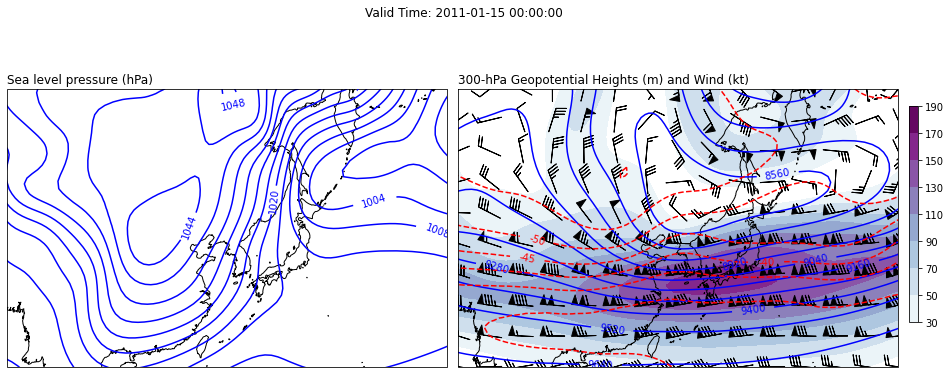

In [9]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(13, 6))
ax = fig.add_subplot(121, projection=mapcrs)

## Surface
domain = [90, 160, 20, 60]
ax.set_extent(domain, ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, msl.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(ax, lons, lats, domain, msl.m, 'max', 50,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(ax, lons, lats, domain, msl.m, 'min', 25,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
ax.set_title('Sea level pressure (hPa)',
           loc='left')

## pressure level
ax2 = fig.add_subplot(122, projection=mapcrs)
ax2.set_extent(domain, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_wind = np.arange(30, 200, 20)
cf = ax2.contourf(lons, lats, wind, clevs_wind, cmap=plt.cm.BuPu,
                 transform=datacrs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.25, 0.01, 0.5])
fig.colorbar(cf, orientation='vertical', shrink=0.5, cax=cbar_ax)

# Plot 500-hPa Geopotential Heights in meters
clevs_gh = np.arange(40, 15000, 120)
cs = ax2.contour(lons, lats, gh, clevs_gh, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa temperatue in degC
clevs_t = np.arange(-60, 5, 5)
cs = ax2.contour(lons, lats, t.to('degC'), clevs_t, colors='red', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax2.barbs(lons, lats, u.to('kt').m, v.to('kt').m, pivot='middle',regrid_shape=10, 
         color='black',  transform=datacrs)

# Make some nice titles for the plot (one right, one left)
ax2.set_title('300-hPa Geopotential Heights (m) and Wind (kt)'
              ,loc='left')
fig.suptitle('Valid Time: {}'.format(vtime))

# Adjust image and show
fig.tight_layout(rect=[0, 0, 0.975, 0.99])

In [7]:
def plot_maxmin_points(ax, lon, lat, domain, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        if (lon[mxx[i], mxy[i]] > domain[0]) & (lon[mxx[i], mxy[i]] < domain[1]) & (lat[mxx[i], mxy[i]] > domain[2]) & (lat[mxx[i], mxy[i]] < domain[3]):
            ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
            ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
            ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
            ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)

# 연직단면도 그리기

In [5]:
data = ds2.metpy.parse_cf()
start = (45., 125.)
end = (25., 135.)
cross = cross_section(data, start, end)
cross.set_coords(('latitude','longitude'))

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


<xarray.Dataset>
Dimensions:    (index: 100, level: 8, time: 1)
Coordinates:
  * level      (level) int32 200 300 500 600 700 850 925 1000
  * time       (time) datetime64[ns] 2011-01-15
    crs        object Projection: latitude_longitude
    longitude  (index) float64 125.0 125.1 125.3 125.4 ... 134.8 134.9 135.0
    latitude   (index) float64 45.0 44.8 44.61 44.41 ... 25.62 25.41 25.21 25.0
  * index      (index) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    t          (time, level, index) float64 225.0 225.3 225.6 ... 294.0 294.0
    z          (time, level, index) float64 1.088e+05 1.089e+05 ... 1.133e+03
    u          (time, level, index) float64 14.69 16.0 17.33 ... -2.282 -2.913
    v          (time, level, index) float64 -6.559 -6.426 -6.299 ... 6.416 6.404
    q          (time, level, index) float64 3.086e-06 3.086e-06 ... 0.007583
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-18 14:53:30 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [10]:
temperature, pressure, specific_humidity = xr.broadcast(cross['t'],
                                                        cross['level'],
                                                        cross['q'])

theta = mpcalc.potential_temperature(pressure, temperature)
rh = mpcalc.relative_humidity_from_specific_humidity(specific_humidity, temperature, pressure)

# These calculations return unit arrays, so put those back into DataArrays in our Dataset
cross['Potential_temperature'] = xr.DataArray(theta,
                                              coords=temperature.coords,
                                              dims=temperature.dims,
                                              attrs={'units': theta.units})
cross['Relative_humidity'] = xr.DataArray(rh,
                                          coords=specific_humidity.coords,
                                          dims=specific_humidity.dims,
                                          attrs={'units': rh.units})

cross['u'].metpy.convert_units('m/s')
cross['v'].metpy.convert_units('m/s')
cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(cross['u'],
                                                         cross['v'])

print(cross)

<xarray.Dataset>
Dimensions:                (index: 100, level: 8, time: 1)
Coordinates:
  * level                  (level) int32 200 300 500 600 700 850 925 1000
  * time                   (time) datetime64[ns] 2011-01-15
    crs                    object Projection: latitude_longitude
    longitude              (index) float64 125.0 125.1 125.3 ... 134.9 135.0
    latitude               (index) float64 45.0 44.8 44.61 ... 25.41 25.21 25.0
  * index                  (index) int32 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    t                      (time, level, index) float64 225.0 225.3 ... 294.0
    z                      (time, level, index) float64 1.088e+05 ... 1.133e+03
    u                      (time, level, index) float64 14.69 16.0 ... -2.913
    v                      (time, level, index) float64 -6.559 -6.426 ... 6.404
    q                      (time, level, index) float64 3.086e-06 ... 0.007583
    Potential_temperature  (time, level, index) float64 <Quantit

C:\Users\DongGyu_Hyeon\Miniconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


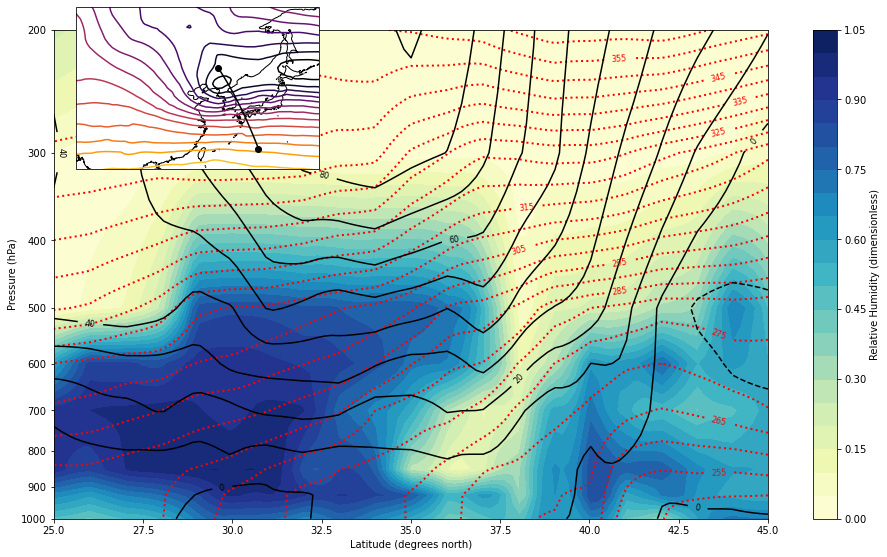

In [17]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['latitude'], cross['level'][::-1], cross['Relative_humidity'].sel(time=dt)[::-1,:],
                         levels=np.arange(0, 1.1, .05), cmap='YlGnBu')
rh_colorbar = fig.colorbar(rh_contour)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['latitude'], cross['level'][::-1], cross['Potential_temperature'].sel(time=dt)[::-1,:],
                           levels=np.arange(250, 450, 5), colors='r', linestyles='dotted', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=8, colors='r', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

wind_contour = ax.contour(cross['latitude'], cross['level'][::-1],
               cross['n_wind'].sel(time=dt)[::-1,:], levels=np.arange(-50,150,10), colors='k')
wind_contour.clabel(wind_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)


# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 150, -100))
ax.set_ylim(cross['level'].max(), cross['level'].min())
ax.set_yticks(np.arange(1000, 150, -100))

# Define the CRS and inset axes
#data_crs = data['z'].metpy.cartopy_crs
datacrs = ccrs.PlateCarree()
ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=datacrs)
ax_inset.set_extent([90, 150, 20, 60], datacrs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data['longitude'].sel(longitude=slice(60,201)), data['latitude'].sel(latitude=slice(90,0)),
                 data['z'].sel(time=dt, level=500., latitude=slice(90,0), longitude=slice(60,201))/g,
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = datacrs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=2)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
#ax.set_title('NARR Cross-Section \u2013 {} to {} \u2013 Valid: {}\n'
#             'Potential Temperature (K), Tangential/Normal Winds (knots), '
#             'Relative Humidity (dimensionless)\n'
#             'Inset: Cross-Section Path and 500 hPa Geopotential Height'.format(
#                 start, end, cross['time'].dt.strftime('%Y-%m-%d %H:%MZ').item()))
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Latitude (degrees north)')
rh_colorbar.set_label('Relative Humidity (dimensionless)')

plt.show()

In [43]:
station = 'RKSO'

# 'RKSO': 오산
# 'RKSP': 백령도
# 'RKTH': 포항
# 'RKTD': 대전
# 'RKJJ': 광주
# 'RKPC': 제주
# 'RKNN': 강릉

In [44]:
# Read remote sounding data based on time (dt) and station
df = WyomingUpperAir.request_data(dt, station)

# Create dictionary of united arrays
data2 = pandas_dataframe_to_unit_arrays(df)

In [45]:
# Isolate united arrays from dictionary to individual variables
p = data2['pressure']
T = data2['temperature']
Td = data2['dewpoint']
u = data2['u_wind']
v = data2['v_wind']

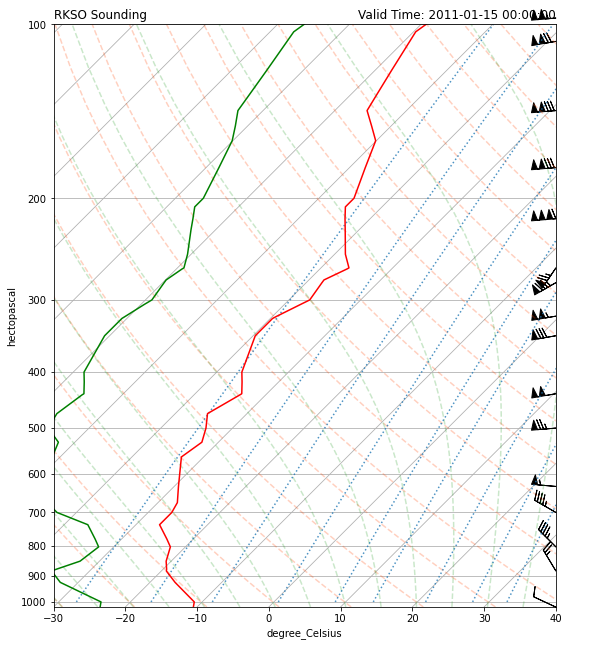

In [46]:
# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::3], u[::3], v[::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Add some descriptive titles
plt.title('{} Sounding'.format(station), loc='left')
plt.title('Valid Time: {}'.format(dt), loc='right');